# Emojify! 

Builing an an Emojifier. 🤩 💫 🔥

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. 
Rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

This is the model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

🏀 👑

👆 😎

## Table of Contents

- [Packages](#0)
- [1 - Baseline Model: Emojifier-V1](#1)
    - [1.1 - Dataset EMOJISET](#1-1)
    - [1.2 - Overview of the Emojifier-V1](#1-2)
    - [1.3 - Implementing Emojifier-V1](#1-3)
        - [Exercise 1 - sentence_to_avg](#ex-1)
    - [1.4 - Implement the Model](#1-4)
        - [Exercise 2 - model](#ex-2)
    - [1.5 - Examining Test Set Performance](#1-5)
- [2 - Emojifier-V2: Using LSTMs in Keras](#2)
    - [2.1 - Model Overview](#2-1)
    - [2.2 Keras and Mini-batching](#2-2)
    - [2.3 - The Embedding Layer](#2-3)
        - [Exercise 3 - sentences_to_indices](#ex-3)
        - [Exercise 4 - pretrained_embedding_layer](#ex-4)
    - [2.4 - Building the Emojifier-V2](#2-4)
        - [Exercise 5 - Emojify_V2](#ex-5)
    - [2.5 - Train the Model](#2-5)
- [3 - Acknowledgments](#3)

<a name='0'></a>
## Packages

In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline

<a name='1'></a>
## 1 - Baseline Model: Emojifier-V1

<a name='1-1'></a>
### 1.1 - Dataset EMOJISET

Let's start by building a simple baseline classifier. 

The dataset is split between training (127 examples) and testing (56 examples).

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
maxLen = len(max(X_train, key=len).split())

In [4]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


#### One-hot Encoding

In [5]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [6]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


All the data is now ready to be fed into the Emojify-V1 model.

<a name='1-3'></a>
### 1.3 - Implementing Emojifier-V1

Similar to this week's previous assignment, We'll use pre-trained 50-dimensional GloVe embeddings. 

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

Loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

In [8]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


<a name='1'></a>
### Sentence_to_avg

Implementing `sentence_to_avg()`

In [9]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (J,), where J can be any number
    """
    # Getting a valid word contained in the word_to_vec_map. 
    any_word = list(word_to_vec_map.keys())[0]
    
    # Splitting sentence into list of lower case words
    words = sentence.lower().split()

    # Average word vector, should have the same shape as your word vectors.
    avg = np.zeros(word_to_vec_map[any_word].shape)

    count = 0
    
    # averaging the word vectors. Loop over the words in the list "words".
    for w in words:
        # If word exists in word_to_vec_map
        if w in list(word_to_vec_map.keys()):
            avg += word_to_vec_map[w]
            count +=1        
    if count > 0:
        avg = avg/count
    
    return avg

<a name='1-4'></a>
### 1.4 - Implement the Model

We now have all the pieces to finish implementing the `model()` function! 
After using `sentence_to_avg()` we need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

<a name='2'></a>
### Model

Implementing the `model()` function. 

* Forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = Wavg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

In [11]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m,)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # A valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Defining number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initializing parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    for t in range(num_iterations): # Loop over the number of iterations
        cost = 0
        dW = 0
        db = 0
        for i in range(m):
            # Averaging the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagation the avg through the softmax layer. 
            z = np.add(np.dot(W,avg),b)
            a = softmax(z)

            # Cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost += -np.sum(np.dot(Y_oh[i],np.log(a)))

            # Computing gradients 
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db += dz

            # Updating parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db  
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)
    return pred, W, b

In [13]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 410.4336578831472
Accuracy: 0.5454545454545454
Epoch: 100 --- cost = 63.612639746961435
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.7391301193275178
Accuracy: 1.0
Epoch: 300 --- cost = 0.3104825413333956
Accuracy: 1.0
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [2.]
 [2.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [0.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]
 [0.]
 [4.]
 [0.]
 [3.]
 [3.]
 [4

<a name='1-5'></a>
### 1.5 - Examining Test Set Performance 

In [14]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 1.0
Test set:
Accuracy: 0.9107142857142857


In [15]:
X_my_sentences = np.array(["i cherish you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i cherish you 😄
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😞


* Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. 
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*.

#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

#### Confusion Matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            1    0   17    0    0   18
3            1    0    2   13    0   16
4            0    0    0    0    7    7
All          8    8   19   14    7   56


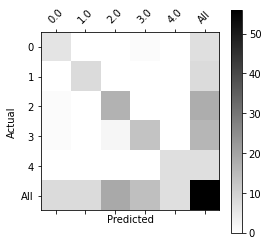

In [16]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<a name='2'></a>
## 2 - Emojifier-V2: Using LSTMs in Keras 

We're going to build an LSTM model that takes word **sequences** as input! This model will be able to account for word ordering. 

Emojifier-V2 will continue to use pre-trained word embeddings to represent words. We'll feed word embeddings into an LSTM, and the LSTM will learn to predict the most appropriate emoji. 

### Packages

In [21]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

<a name='3'></a>
### Sentences_to_indices

Implementing `sentences_to_indices`

In [18]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [22]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0] # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros([m,max_len])
    
    for i in range(m):
        # Converting the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Setting the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                j =  j + 1  
    return X_indices

In [24]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


#### Building Embedding Layer
<a name='ex-4'></a>
### Pretrained_embedding_layer

Implementing `pretrained_embedding_layer()`

In [25]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # dimensionality of GloVe word vectors
      
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros([vocab_size,emb_dim])
    
    # Setting each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] =  word_to_vec_map[word]
    # Keras embedding layer with the correct input and output sizes
    # It is non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim ,trainable = False)

    # Building the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Setting the weights of the embedding layer to the embedding matrix. Layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [27]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


In [28]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # sentence_indices as the input of the graph.
    sentence_indices = Input(shape = input_shape,dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagating sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagating the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128,return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
    # Propagating X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128,return_sequences = False)(X)
    X = Dropout(0.5)(X) 
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices,outputs=X)
    
    return model

In [30]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

#### Compiling the Model

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<a name='2-5'></a>
### 2.5 - Training the Model 

In [32]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [33]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 30ms/step - loss: 1.6250 - accuracy: 0.2045
Epoch 2/50
5/5 [==============================] - 0s 39ms/step - loss: 1.5513 - accuracy: 0.3106
Epoch 3/50
5/5 [==============================] - 0s 35ms/step - loss: 1.4882 - accuracy: 0.4167
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 1.4090 - accuracy: 0.3939
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 1.3124 - accuracy: 0.4773
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 1.1984 - accuracy: 0.6136
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 1.0800 - accuracy: 0.6364
Epoch 8/50
5/5 [==============================] - 0s 34ms/step - loss: 0.9329 - accuracy: 0.6364
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 0.8167 - accuracy: 0.6894
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 0.7547 - accuracy: 0.7273
Epoch 11/50
5/5 [============

In [34]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.8214

Test accuracy =  0.8214285969734192


In [35]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾


In [36]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['I cannot play'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I cannot play ⚾
